# Chainer basic module introduction 2

Advanced memo is written as "Note". You can skip reading this for the first time reading.

In previous tutorial, we learned
* Variable
* Link
* Function
* Chain

Let's try training the model (Chain) in this tutorial.
In this section, we will learn

* Optimizer   - Optimizes/tunes the internal parameter to fit to the target function
* Serializer  - Handle save/load the model (Chain)

For other chainer modules are explained in later tutorial.

## Training

What we want to do here is regression analysis (Wikipedia).
Given set of input `x` and its output `y`, 
we would like to construct a model (function) which estimates `y` as close as possible from given input `x`.

This is done by tuning an internal parameters of model (this is represented by Chain class in Chainer).
And the procedure to tune this internal parameters of model to get a desired model is often denoted as "training".

## Initial setup

Below is typecal `import` statement of chainer modules.

In [1]:
# Initial setup following http://docs.chainer.org/en/stable/tutorial/basic.html
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

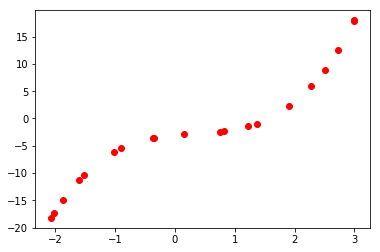

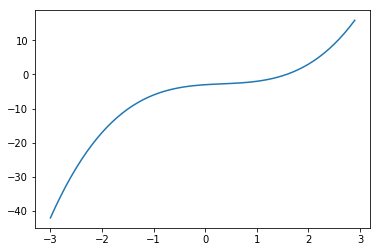

In [2]:
import matplotlib.pyplot as plt


# define target function
def target_func(x):
    """Target function to be predicted"""
    return x ** 3 - x ** 2 + x - 3

# create efficient function to calculate target_func of numpy array in element wise
target_func_elementwise = np.frompyfunc(target_func, 1, 1)


# define data domain [xmin, xmax]
xmin = -3
xmax = 3
# number of training data
sample_num = 20
x_data = np.array(np.random.rand(sample_num) * (xmax - xmin) + xmin)  # create 20 
y_data = target_func_elementwise(x_data)

x_detail_data = np.array(np.arange(xmin, xmax, 0.1))
y_detail_data = target_func_elementwise(x_detail_data)


# plot training data
plt.clf()
plt.scatter(x_data, y_data, color='r')
plt.show()
#print('x', x_data, 'y', y_data)

# plot target function
plt.clf()
plt.plot(x_detail_data, y_detail_data)
plt.show()

Our task is to make regression 

## Linear regression using sklearn

You can skip this section if you are only interested in Chainer or deep learning.
At first, let's see linear regression approach. 
using sklearn library, 

Reference: [http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

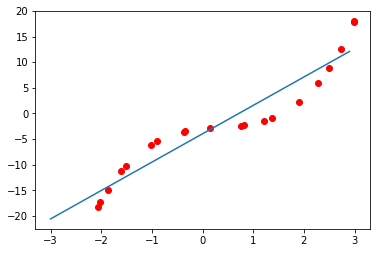

In [4]:
from sklearn import linear_model

# clf stands for 'classifier'
model = linear_model.LinearRegression()
model.fit(x_data.reshape(-1, 1), y_data)

y_predict_data = model.predict(x_detail_data.reshape(-1, 1))
plt.clf()
plt.scatter(x_data, y_data, color='r')
plt.plot(x_detail_data, y_predict_data)
plt.show()

## Optimizer
Chainer optimizer manages the optimization process of model fit.

Concretely, current deep learning works based on the technic of Stocastic Gradient Descent (SGD) based method.
Chainer provides several optimizers in `chainer.optimizers` module, which includes following

* SGD
* MomentumSGD
* AdaGrad
* AdaDelta
* Adam

Around my community, MomentumSGD and Adam are more used these days.

## Construct model - implement your own Chain

`Chain` is to construct neural networks.

Let's see example,

In [5]:
from chainer import Chain, Variable


# Defining your own neural networks using `Chain` class
class MyChain(Chain):
    def __init__(self):
        super(MyChain, self).__init__(
            l1=L.Linear(None, 30),
            l2=L.Linear(None, 30),
            l3=L.Linear(None, 1)
        )
        
    def __call__(self, x):
        h = self.l1(x)
        h = self.l2(F.sigmoid(h))
        return self.l3(F.sigmoid(h))

Here `L.Linear` is defined with `None` in first argument, input size.
When `None` is used, Linear Link will determine its input size at the first time when it gets the input Variable.
In other words, Link's input size can be dynamically defined and you don't need to fix the size at the declaration timing.
This flexibility comes from the Chainer's concept "define by run". 

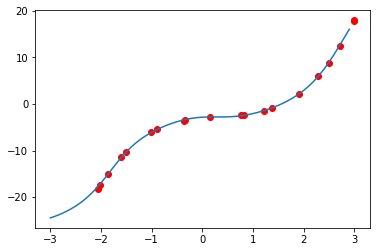

In [6]:
# Setup a model
model = MyChain()
# Setup an optimizer
optimizer = chainer.optimizers.MomentumSGD()
optimizer.use_cleargrads()  # this is for performance efficiency
optimizer.setup(model)

x = Variable(x_data.reshape(-1, 1).astype(np.float32))
y = Variable(y_data.reshape(-1, 1).astype(np.float32))


def lossfun(x, y):
    loss = F.mean_squared_error(model(x), y)
    return loss

# this iteration is "training", to fit the model into desired function.
for i in range(300):
    optimizer.update(lossfun, x, y)

    # above one code can be replaced by below 4 codes.
    # model.cleargrads()
    # loss = lossfun(x, y)
    # loss.backward()
    # optimizer.update()


y_predict_data = model(x_detail_data.reshape(-1, 1).astype(np.float32)).data

plt.clf()
plt.scatter(x_data, y_data, color='r')
plt.plot(x_detail_data, np.squeeze(y_predict_data, axis=1))
plt.show()

Notes for data shape: `x_data` and `y_data` are reshaped when Variable is made. `Linear` function input and output is of the form (batch_index, feature_index). 
In this example, `x_data` and `y_data` have 1 dimensional feature with the batch_size = sample_num (20).

At first, optimizer is set up as following code.
We can choose which kind of optimizing method is used during training (in this case, MomentumSGD is used). 

```
# Setup an optimizer
optimizer = chainer.optimizers.MomentumSGD()
optimizer.use_cleargrads()  # this is for performance efficiency
optimizer.setup(model)
```

Once optimizer is setup, training proceeds with iterating following code.
```
optimizer.update(lossfun, x, y)
```

By the update, optimizer tries to tune internal parameters of model by decreasing the loss defined by `lossfun`.
In this example, squared error is used as loss
```
def lossfun(x, y):
    loss = F.mean_squared_error(model(x), y)
    return loss
```

## Serializer
Serializer supports save/load of Chainer's class.

After training finished, we want to save the model so that we can load it in inference stage.
Another usecase is that we want to save the optimizer together with the model so that we can abort and restart the training. 

The code below is almost same with the training code above.
Only the difference is that 
`serializers.load_npz()` (or `serializers.load_hdf5()`) and 
`serializers.save_npz()` (or `serializers.save_hdf5()` are implemented.
So now it supports resuming training, by implemeting save/load.

Note that `model` and `optimizer` need to be instantiated to appropriate class before load.

Loading model & optimizer
saving model & optimizer


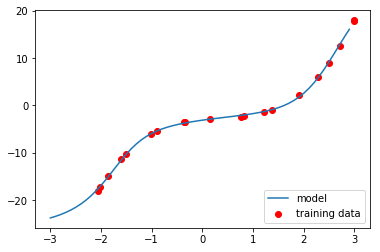

In [25]:
# Execute with resume = False at first time
# Then execute this code again and again by with resume = True
resume = False

# Setup a model
model = MyChain()
# Setup an optimizer
optimizer = chainer.optimizers.MomentumSGD()
optimizer.setup(model)

x = Variable(x_data.reshape(-1, 1).astype(np.float32))
y = Variable(y_data.reshape(-1, 1).astype(np.float32))

model_save_path = 'mlp.model'
optimizer_save_path = 'mlp.state'

# Init/Resume
if resume:
    print('Loading model & optimizer')
    # --- use NPZ format ---
    serializers.load_npz(model_save_path, model)
    serializers.load_npz(optimizer_save_path, optimizer)
    # --- use HDF5 format (need h5py library) ---
    #%timeit serializers.load_hdf5(model_save_path, model)
    #serializers.load_hdf5(optimizer_save_path, optimizer)


def lossfun(x, y):
    loss = F.mean_squared_error(model(x), y)
    return loss

# this iteration is "training", to fit the model into desired function.
# Only 20 iteration is not enough to finish training,
# please execute this code several times by setting resume = True
for i in range(20):
    optimizer.update(lossfun, x, y)

    # above one code can be replaced by below 4 codes.
    # model.cleargrads()
    # loss = lossfun(x, y)
    # loss.backward()
    # optimizer.update()

# Save the model and the optimizer
print('saving model & optimizer')

# --- use NPZ format ---
serializers.save_npz(model_save_path, model)
serializers.save_npz(optimizer_save_path, optimizer)
# --- use HDF5 format (need h5py library) ---
#%timeit serializers.save_hdf5(model_save_path, model)
# serializers.save_hdf5(optimizer_save_path, optimizer)

y_predict_data = model(x_detail_data.reshape(-1, 1).astype(np.float32)).data

plt.clf()
plt.scatter(x_data, y_data, color='r', label='training data')
plt.plot(x_detail_data, np.squeeze(y_predict_data, axis=1), label='model')
plt.legend(loc='lower right')
plt.show()

Please execute above by setting `resume = False` at the first time, and then please execute the same code several times by setting `resume = True`.

You can see "the dynamics" of how the model fits to the data by training proceeds. 

### Save format
Chainer supports two format, *NPZ* and *HDF5*.

- NPZ  : Supported in numpy. So it does not require additional environment setup.
- HDF5 : Supported in h5py library. It is usually **faster** than npz format, but you need to install the library.

In my environment, it took

- NPZ :  load 2.5ms, save 22ms
- HDF5: load 2.0ms, save 15ms

In one words, I recommend to use HDF5 format version, `serializers.save_hdf5()` and `serializers.load_hdf5()`.
Just run `pip install h5py` if you haven't install the library.

## Predict

Once the model is trained, you can apply this model to new data.

Compared to "training", this is often called "predict" or "inference".

Loading model


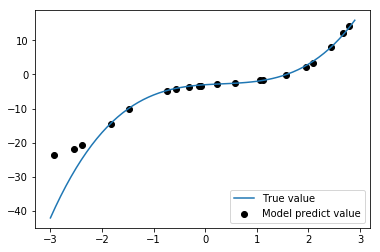

In [26]:
# Setup a model
model = MyChain()

model_save_path = 'mlp.model'
print('Loading model')
# --- use NPZ format ---
serializers.load_npz(model_save_path, model)
# --- use HDF5 format (need h5py library) ---
#%timeit serializers.load_hdf5(model_save_path, model)


# calculate new data from model (predict value)
x_test_data = np.array(np.random.rand(sample_num) * (xmax - xmin) + xmin)  # create 20 
x_test = Variable(x_test_data.reshape(-1, 1).astype(np.float32))
y_test_data = model(x_test).data  # this is predicted value

# calculate target function (true value)
x_detail_data = np.array(np.arange(xmin, xmax, 0.1))
y_detail_data = target_func_elementwise(x_detail_data)

plt.clf()
# plot model predict data
plt.scatter(x_test_data, y_test_data, color='k', label='Model predict value')
# plot target function
plt.plot(x_detail_data, y_detail_data, label='True value')
plt.legend(loc='lower right')
plt.show()

Compare with the black dot and blue line.

It is preferable if the black dot is as close as possible to the blue line.
If you train the model with enough iteration, black dot should be shown almost on the blue line in this easy example.

## Summary

You learned Optimizers and Serializers module, and how these are used in training code.
Optimizers update the model (Chain instance) to fit to the data.
Serializers provides save/load functionality to chainer module, especially model and optimizer.

Now you understand the very basic modules of Chainer. So let's proceed to MNIST example, this is considered as "hello world" program in machine learning community.